## Sentminet Analysis for Dashn

This notebook is used to perform sentiment analysis on the reviews of DashN

## Setup and Imports

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys



In [8]:
# Text processing and sentiment analysis
import vaderSentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



# List all available styles


In [16]:
# List all available styles
print("Available styles:", plt.style.available)

# Use a valid style - try 'seaborn-v0_8' or 'seaborn-darkgrid' if available
plt.style.use('seaborn-v0_8')  # or 'seaborn-darkgrid', 'seaborn-whitegrid', etc.
sns.set_palette("viridis")

Available styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Load the data

In [17]:
def load_bank_data(bank_name: str = 'dashn') -> Optional[pd.DataFrame]:
    """
    Load and validate preprocessed bank review data with enhanced error reporting.
    """
    try:
        # Normalize bank name and handle common variations
        bank_name = bank_name.lower().strip()
        bank_name = 'dashen' if bank_name == 'dashn' else bank_name
        
        # Use pathlib for cross-platform compatibility
        data_dir = Path('C:/Users/My Device/Desktop/Week-2/data/processed')
        file_path = data_dir / f'cleaned_bank_reviews_{bank_name}.csv'
        
        print(f"🔍 Looking for data file at: {file_path}")
        
        if not file_path.exists():
            print(f"❌ File not found at: {file_path}")
            available_files = list(data_dir.glob('cleaned_bank_reviews_*.csv'))
            print(f"📂 Available files: {[f.name for f in available_files]}")
            return None
        
        # First, read just the first row to check columns
        with open(file_path, 'r', encoding='utf-8') as f:
            first_line = f.readline().strip()
            print(f"📄 First line of file: {first_line}")
            
        # Now try to load the full data
        bank_data = pd.read_csv(file_path)
        print("✅ Successfully loaded CSV. Columns found:", bank_data.columns.tolist())
        
        # Convert date column if it exists
        if 'date' in bank_data.columns:
            bank_data['date'] = pd.to_datetime(bank_data['date'])
            print("✅ Converted 'date' column to datetime")
            
        # Rename 'review' to 'review_text' if needed
        if 'review' in bank_data.columns and 'review_text' not in bank_data.columns:
            bank_data = bank_data.rename(columns={'review': 'review_text'})
            print("✅ Renamed 'review' column to 'review_text'")
            
        # Check for required columns
        required_columns = {'date', 'rating', 'review_text'}
        missing = required_columns - set(bank_data.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")
            
        print(f"✅ Successfully processed {len(bank_data)} records")
        return bank_data
        
    except Exception as e:
        print("\n" + "❌" * 20)
        print(f"ERROR DETAILS:\n{str(e)}")
        print("❌" * 20 + "\n")
        import traceback
        traceback.print_exc()
        return None

# Test the function
print("\n" + "="*50)
print("TESTING DATA LOADING...")
print("="*50)
bank_data = load_bank_data('dashn')

if bank_data is not None:
    print("\n" + "="*50)
    print("DATA LOADED SUCCESSFULLY!")
    print("="*50)
    print("\nFirst few rows of data:")
    display(bank_data.head(2))
    print("\nDataFrame info:")
    bank_data.info()
else:
    print("\n" + "="*50)
    print("FAILED TO LOAD DATA")
    print("="*50)


TESTING DATA LOADING...
🔍 Looking for data file at: C:\Users\My Device\Desktop\Week-2\data\processed\cleaned_bank_reviews_dashen.csv
📄 First line of file: review,rating,date,bank,source
✅ Successfully loaded CSV. Columns found: ['review', 'rating', 'date', 'bank', 'source']
✅ Converted 'date' column to datetime
✅ Renamed 'review' column to 'review_text'
✅ Successfully processed 753 records

DATA LOADED SUCCESSFULLY!

First few rows of data:


,review_text,rating,date,bank,source
0,The Dashen Super App is very impressive. It is...,5,2025-11-05,DASHEN,Google Play Store
1,"@Shewangizaw L. As a heavy user of the app , t...",4,2025-10-06,DASHEN,Google Play Store



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_text  753 non-null    object        
 1   rating       753 non-null    int64         
 2   date         753 non-null    datetime64[ns]
 3   bank         753 non-null    object        
 4   source       753 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 29.5+ KB


## Initialize Sentiment Analyser

In [18]:
class SentimentAnalyzerDashen:
    """
    Optimized Sentiment Analyzer for Dashen Bank reviews with enhanced error handling and performance.
    Customized thresholds for Dashen Bank review patterns.
    """
    def __init__(self):
        """Initialize with VADER and TextBlob with custom lexicon adjustments."""
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        from textblob import TextBlob
        import logging
        
        # Initialize TextBlob
        self.TextBlob = TextBlob
        
        # Initialize VADER with custom lexicon
        self.analyzer = SentimentIntensityAnalyzer()
        self._update_lexicon()
        
        # Setup logging
        self.logger = self._setup_logger()
    
    def _update_lexicon(self):
        """Update VADER lexicon with banking-specific terms for Dashen Bank."""
        banking_lexicon = {
            'super app': 1.5,
            'dashen': 0.5,  # Slightly positive for brand mention
            'app': 0.3,     # Slightly positive for app mention
            'update': 0.2,  # Neutral to slightly positive for updates
            'error': -1.5,  # Strong negative for technical issues
            'slow': -1.2,   # Negative for performance issues
            'crash': -1.8,  # Very negative
            'hack': -2.0,   # Very negative for security concerns
            'thank': 1.0,   # Positive for gratitude
            'helpful': 1.2, # Positive for helpful features
            'easy': 1.0     # Positive for ease of use
        }
        
        # Update the VADER lexicon
        self.analyzer.lexicon.update(banking_lexicon)
    
    def _setup_logger(self):
        """Configure and return a logger instance."""
        import logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        return logging.getLogger('Dashen_Sentiment_Analyzer')
    
    def analyze_textblob(self, text):
        """Analyze sentiment using TextBlob with enhanced error handling."""
        try:
            # Preprocess text - remove common issues
            text = str(text).strip()
            if not text or text.lower() in ['na', 'n/a', 'none', '']:
                return {'polarity': 0, 'subjectivity': 0, 'sentiment': 'neutral'}
                
            analysis = self.TextBlob(text)
            return {
                'polarity': analysis.sentiment.polarity,
                'subjectivity': analysis.sentiment.subjectivity,
                'sentiment': self._categorize_sentiment(analysis.sentiment.polarity)
            }
        except Exception as e:
            self.logger.error(f"TextBlob analysis failed: {str(e)}")
            return {'polarity': 0, 'subjectivity': 0, 'sentiment': 'error'}
    
    def analyze_vader(self, text):
        """Analyze sentiment using VADER with enhanced error handling."""
        try:
            text = str(text).strip()
            if not text or text.lower() in ['na', 'n/a', 'none', '']:
                return {'vader_compound': 0, 'vader_sentiment': 'neutral'}
                
            vs = self.analyzer.polarity_scores(text)
            return {
                'vader_compound': vs['compound'],
                'vader_positive': vs['pos'],
                'vader_negative': vs['neg'],
                'vader_neutral': vs['neu'],
                'vader_sentiment': self._categorize_vader(vs['compound'])
            }
        except Exception as e:
            self.logger.error(f"VADER analysis failed: {str(e)}")
            return {
                'vader_compound': 0,
                'vader_positive': 0,
                'vader_negative': 0,
                'vader_neutral': 1,
                'vader_sentiment': 'error'
            }
    
    @staticmethod
    def _categorize_sentiment(score):
        """Categorize TextBlob score with Dashen-specific thresholds."""
        thresholds = {
            'positive': 0.15,    # Slightly higher threshold for positive
            'negative': -0.15    # Slightly lower threshold for negative
        }
        if score > thresholds['positive']:
            return 'positive'
        if score < thresholds['negative']:
            return 'negative'
        return 'neutral'
    
    @staticmethod
    def _categorize_vader(score):
        """Categorize VADER score with Dashen-specific thresholds."""
        thresholds = {
            'positive': 0.10,    # More sensitive to positive sentiment
            'negative': -0.10    # More sensitive to negative sentiment
        }
        if score >= thresholds['positive']:
            return 'positive'
        if score <= thresholds['negative']:
            return 'negative'
        return 'neutral'
    
    def analyze_reviews(self, reviews, batch_size=100, text_column='review_text'):
        """
        Analyze a collection of reviews with progress tracking.
        
        Args:
            reviews: DataFrame or list of reviews
            batch_size: Number of reviews to process before logging progress
            text_column: Name of the column containing review text (if reviews is a DataFrame)
            
        Returns:
            pd.DataFrame: Original data with added sentiment analysis columns
        """
        import pandas as pd
        from tqdm.notebook import tqdm
        import numpy as np
        
        # Convert to DataFrame if it's a list
        if isinstance(reviews, list):
            reviews = pd.DataFrame({text_column: reviews})
        
        results = []
        self.logger.info(f"Starting analysis of {len(reviews)} reviews...")
        
        # Initialize progress bar
        tqdm.pandas(desc="Analyzing reviews")
        
        # Process each review
        for idx, row in tqdm(reviews.iterrows(), total=len(reviews)):
            review_text = row[text_column] if text_column in row else row
            tb_result = self.analyze_textblob(review_text)
            vader_result = self.analyze_vader(review_text)
            
            # Combine results
            result = {
                'review_id': idx,
                'review_text': review_text,
                **tb_result,
                **vader_result
            }
            
            # Add any additional columns from the original data
            if isinstance(reviews, pd.DataFrame):
                for col in reviews.columns:
                    if col != text_column:
                        result[col] = row[col]
            
            results.append(result)
        
        self.logger.info("Analysis completed successfully")
        return pd.DataFrame(results)

# Initialize the analyzer with logging
print("Initializing Dashen Bank Sentiment Analyzer...")
analyzer = SentimentAnalyzerDashen()
print("Dashen Bank Sentiment Analyzer is ready!")

# Example usage:
# if bank_data is not None:
#     sentiment_results = analyzer.analyze_reviews(bank_data, text_column='review_text')
#     print("\nSentiment Analysis Results:")
#     display(sentiment_results.head(3))

Initializing Dashen Bank Sentiment Analyzer...
Dashen Bank Sentiment Analyzer is ready!


## Performing Sentiment Analyis for Dashn

In [19]:
# First, let's define the SentimentAnalyzerDashen class
class SentimentAnalyzerDashen:
    """
    Optimized Sentiment Analyzer for Dashen Bank reviews with enhanced error handling and performance.
    Customized for banking-specific terminology and review patterns.
    """
    def __init__(self):
        """Initialize with VADER and TextBlob with custom lexicon adjustments."""
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        from textblob import TextBlob
        import logging
        
        # Initialize TextBlob
        self.TextBlob = TextBlob
        
        # Initialize VADER with custom lexicon
        self.analyzer = SentimentIntensityAnalyzer()
        self._update_lexicon()
        
        # Setup logging
        self.logger = self._setup_logger()
    
    def _update_lexicon(self):
        """Update VADER lexicon with banking-specific terms for Dashen Bank."""
        banking_lexicon = {
            'super app': 1.5,
            'dashen': 0.5,  # Slightly positive for brand mention
            'app': 0.3,     # Slightly positive for app mention
            'update': 0.2,  # Neutral to slightly positive for updates
            'error': -1.5,  # Strong negative for technical issues
            'slow': -1.2,   # Negative for performance issues
            'crash': -1.8,  # Very negative
            'hack': -2.0,   # Very negative for security concerns
            'thank': 1.0,   # Positive for gratitude
            'helpful': 1.2, # Positive for helpful features
            'easy': 1.0     # Positive for ease of use
        }
        
        # Update the VADER lexicon
        self.analyzer.lexicon.update(banking_lexicon)
    
    def _setup_logger(self):
        """Configure and return a logger instance."""
        import logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        return logging.getLogger('Dashen_Sentiment_Analyzer')
    
    def analyze_textblob(self, text):
        """Analyze sentiment using TextBlob with enhanced error handling."""
        try:
            text = str(text).strip()
            if not text or text.lower() in ['na', 'n/a', 'none', '']:
                return {'polarity': 0, 'subjectivity': 0, 'sentiment': 'neutral'}
                
            analysis = self.TextBlob(text)
            return {
                'polarity': analysis.sentiment.polarity,
                'subjectivity': analysis.sentiment.subjectivity,
                'sentiment': self._categorize_sentiment(analysis.sentiment.polarity)
            }
        except Exception as e:
            self.logger.error(f"TextBlob analysis failed: {str(e)}")
            return {'polarity': 0, 'subjectivity': 0, 'sentiment': 'error'}
    
    def analyze_vader(self, text):
        """Analyze sentiment using VADER with enhanced error handling."""
        try:
            text = str(text).strip()
            if not text or text.lower() in ['na', 'n/a', 'none', '']:
                return {'vader_compound': 0, 'vader_sentiment': 'neutral'}
                
            vs = self.analyzer.polarity_scores(text)
            return {
                'vader_compound': vs['compound'],
                'vader_positive': vs['pos'],
                'vader_negative': vs['neg'],
                'vader_neutral': vs['neu'],
                'vader_sentiment': self._categorize_vader(vs['compound'])
            }
        except Exception as e:
            self.logger.error(f"VADER analysis failed: {str(e)}")
            return {
                'vader_compound': 0,
                'vader_positive': 0,
                'vader_negative': 0,
                'vader_neutral': 1,
                'vader_sentiment': 'error'
            }
    
    @staticmethod
    def _categorize_sentiment(score):
        """Categorize TextBlob score with Dashen-specific thresholds."""
        thresholds = {
            'positive': 0.15,    # Slightly higher threshold for positive
            'negative': -0.15    # Slightly lower threshold for negative
        }
        if score > thresholds['positive']:
            return 'positive'
        if score < thresholds['negative']:
            return 'negative'
        return 'neutral'
    
    @staticmethod
    def _categorize_vader(score):
        """Categorize VADER score with Dashen-specific thresholds."""
        thresholds = {
            'positive': 0.10,    # More sensitive to positive sentiment
            'negative': -0.10    # More sensitive to negative sentiment
        }
        if score >= thresholds['positive']:
            return 'positive'
        if score <= thresholds['negative']:
            return 'negative'
        return 'neutral'
    
    def analyze_reviews(self, reviews, text_column='review'):
        """
        Analyze a collection of reviews with progress tracking.
        
        Args:
            reviews: DataFrame or list of reviews
            text_column: Name of the column containing review text (if reviews is a DataFrame)
            
        Returns:
            pd.DataFrame: Analysis results
        """
        import pandas as pd
        from tqdm.notebook import tqdm
        
        # Convert to DataFrame if it's a list
        if isinstance(reviews, list):
            reviews = pd.DataFrame({text_column: reviews})
        
        results = []
        self.logger.info(f"Starting analysis of {len(reviews)} reviews...")
        
        # Process each review
        for idx, row in tqdm(reviews.iterrows(), total=len(reviews), desc="Analyzing reviews"):
            review_text = row[text_column] if text_column in row else row
            tb_result = self.analyze_textblob(review_text)
            vader_result = self.analyze_vader(review_text)
            
            # Combine results
            result = {
                'review_id': idx,
                'review_text': review_text,
                **tb_result,
                **vader_result
            }
            
            # Add any additional columns from the original data
            if isinstance(reviews, pd.DataFrame):
                for col in reviews.columns:
                    if col != text_column:
                        result[col] = row[col]
            
            results.append(result)
        
        self.logger.info("Analysis completed successfully")
        return pd.DataFrame(results)

# Now the analyze_dashen_sentiments function
def analyze_dashen_sentiments(dashen_data, sample_size=None, random_state=42, batch_size=50):
    """
    Perform sentiment analysis on Dashen Bank reviews with progress tracking and error handling.
    Optimized for performance and memory efficiency.
    
    Args:
        dashen_data (pd.DataFrame): DataFrame containing Dashen Bank reviews
        sample_size (int, optional): Number of reviews to analyze. If None, uses all reviews.
        random_state (int): Random seed for reproducibility
        batch_size (int): Number of reviews to process in each batch (for memory efficiency)
        
    Returns:
        pd.DataFrame: Analyzed Dashen Bank reviews with sentiment scores
    """
    import pandas as pd
    import logging
    from tqdm.notebook import tqdm
    import numpy as np
    from datetime import datetime
    
    # Setup logging with Dashen-specific formatting
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - DASHEN - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    logger = logging.getLogger('Dashen_Sentiment_Analysis')
    
    if dashen_data is None or dashen_data.empty:
        logger.error("No Dashen Bank data provided or data is empty")
        return None
    
    # Sample the data if sample_size is provided
    if sample_size and len(dashen_data) > sample_size:
        dashen_data = dashen_data.sample(
            min(sample_size, len(dashen_data)), 
            random_state=random_state
        )
        logger.info(f"Analyzing sample of {len(dashen_data):,} Dashen Bank reviews...")
    else:
        logger.info(f"Analyzing all {len(dashen_data):,} Dashen Bank reviews...")
    
    try:
        # Initialize analyzer
        analyzer = SentimentAnalyzerDashen()
        logger.info("Sentiment analyzer initialized successfully")
        
        # Process in batches for better memory management
        results = analyzer.analyze_reviews(dashen_data, text_column='review')
        
        # Add analysis metadata
        results['analysis_timestamp'] = datetime.now()
        results['bank'] = 'DASHEN'
        
        # Calculate sentiment confidence
        results['sentiment_confidence'] = np.abs(
            results['vader_compound'] * results['polarity']
        )
        
        logger.info(f"✅ Successfully analyzed {len(results):,} Dashen Bank reviews")
        
        # Basic sentiment statistics
        sentiment_dist = results['vader_sentiment'].value_counts(normalize=True) * 100
        logger.info("Sentiment Distribution:\n" + 
                   "\n".join([f"  - {k}: {v:.1f}%" for k, v in sentiment_dist.items()]))
        
        return results
        
    except Exception as e:
        logger.error(f"❌ Error analyzing Dashen Bank data: {str(e)}", exc_info=True)
        return None

# Example usage:
if __name__ == "__main__":
    # Load Dashen data
    dashen_data = load_bank_data('dashen')  # or 'dashn' based on your file naming
    
    if dashen_data is not None:
        # Analyze all Dashen reviews
        dashen_analyzed = analyze_dashen_sentiments(
            dashen_data,
            sample_size=None,  # Set to a number to analyze a sample
            batch_size=100     # Adjust based on your system's memory
        )
        
        if dashen_analyzed is not None:
            print("\nAnalysis completed successfully!")
            print("\nSample of analyzed data:")
            display(dashen_analyzed[[
                'review_text', 
                'rating', 
                'sentiment', 
                'vader_sentiment',
                'sentiment_confidence'
            ]].head())
            
            print(f"\nTotal reviews analyzed: {len(dashen_analyzed):,}")
            print("\nSentiment distribution:")
            print(dashen_analyzed['vader_sentiment'].value_counts(normalize=True).mul(100))
    else:
        print("Failed to load Dashen Bank data")

2025-11-30 21:15:13,284 - INFO - Analyzing all 753 Dashen Bank reviews...
2025-11-30 21:15:13,306 - INFO - Sentiment analyzer initialized successfully
2025-11-30 21:15:13,308 - INFO - Starting analysis of 753 reviews...


🔍 Looking for data file at: C:\Users\My Device\Desktop\Week-2\data\processed\cleaned_bank_reviews_dashen.csv
📄 First line of file: review,rating,date,bank,source
✅ Successfully loaded CSV. Columns found: ['review', 'rating', 'date', 'bank', 'source']
✅ Converted 'date' column to datetime
✅ Renamed 'review' column to 'review_text'
✅ Successfully processed 753 records


Analyzing reviews:   0%|          | 0/753 [00:00<?, ?it/s]

2025-11-30 21:15:16,168 - INFO - Analysis completed successfully
2025-11-30 21:15:16,184 - INFO - ✅ Successfully analyzed 753 Dashen Bank reviews
2025-11-30 21:15:16,195 - INFO - Sentiment Distribution:
  - positive: 96.5%
  - neutral: 3.1%
  - negative: 0.4%



Analysis completed successfully!

Sample of analyzed data:


,review_text,rating,sentiment,vader_sentiment,sentiment_confidence
0,The Dashen Super App is very impressive. It is...,5,positive,positive,0.61160
1,"@Shewangizaw L. As a heavy user of the app , t...",4,negative,positive,0.12074
2,This might be the worst banking app I've ever ...,1,negative,neutral,0.04310
3,What do you care about my phone's settings? Wh...,1,positive,positive,0.39020
4,The Dashen Super App is very impressive. It is...,5,positive,positive,0.61160



Total reviews analyzed: 753

Sentiment distribution:
vader_sentiment
positive    96.547145
neutral      3.054449
negative     0.398406
Name: proportion, dtype: float64


✅ File loaded successfully!
Shape: (753, 15)

First few rows:


,review_id,bank,app_id,review,review_clean,rating,date,thumbs_up,language,scrape_timestamp,translated_review,is_translated,emojis,emoji_count,emoji_descriptions
0,362b7c91-55d7-45f5-bcd5-7088f6b09e3a,DASHEN,com.dashen.dashensuperapp,The Dashen Super App is very impressive. It is...,The Dashen Super App is very impressive. It is...,5,2025-11-05,202,en,2025-11-28 23:37:37,The Dashen Super App is very impressive. It is...,False,[],0,[]
1,fded7d2d-d728-45d8-bbff-d921bb72b84c,DASHEN,com.dashen.dashensuperapp,"@Shewangizaw L. As a heavy user of the app , t...","@Shewangizaw L. As a heavy user of the app , t...",4,2025-10-06,37,en,2025-11-28 23:37:37,"@Shewangizaw L. As a heavy user of the app , t...",False,[],0,[]
2,34e38910-0b27-4048-954e-82aa66d61c43,DASHEN,com.dashen.dashensuperapp,This might be the worst banking app I've ever ...,This might be the worst banking app I've ever ...,1,2025-11-01,481,en,2025-11-28 23:37:37,This might be the worst banking app I've ever ...,False,[],0,[]
3,d29af33e-3f63-4b7e-9312-b63f7d2c6724,DASHEN,com.dashen.dashensuperapp,What do you care about my phone's settings? Wh...,What do you care about my phone's settings? Wh...,1,2025-11-25,0,en,2025-11-28 23:37:37,What do you care about my phone's settings? Wh...,False,[],0,[]
4,eeb816b9-14d4-4d91-a3b5-90b391850faa,DASHEN,com.dashen.dashensuperapp,The Dashen Super App is very impressive. It is...,The Dashen Super App is very impressive. It is...,5,2025-11-19,37,en,2025-11-28 23:37:37,The Dashen Super App is very impressive. It is...,False,[],0,[]



Checking for required columns...

Analyzing sentiment...

Date column found and converted to datetime

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   review_id           753 non-null    object        
 1   bank                753 non-null    object        
 2   app_id              753 non-null    object        
 3   review              753 non-null    object        
 4   review_clean        751 non-null    object        
 5   rating              753 non-null    int64         
 6   date                753 non-null    datetime64[ns]
 7   thumbs_up           753 non-null    int64         
 8   language            753 non-null    object        
 9   scrape_timestamp    753 non-null    object        
 10  translated_review   753 non-null    object        
 11  is_translated       753 non-null    bool  

None


Sentiment Distribution (TextBlob):


sentiment
positive    496
neutral     207
negative     50
Name: count, dtype: int64


Sentiment Distribution (VADER):


vader_sentiment
positive    523
neutral     159
negative     71
Name: count, dtype: int64


Generating visualizations...


2025-11-30 21:17:45,941 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-30 21:17:45,951 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


✅ Visualizations saved to C:/Users/My Device/Desktop/Week-2/data\..\reports\figures\dashen_sentiment_analysis.png


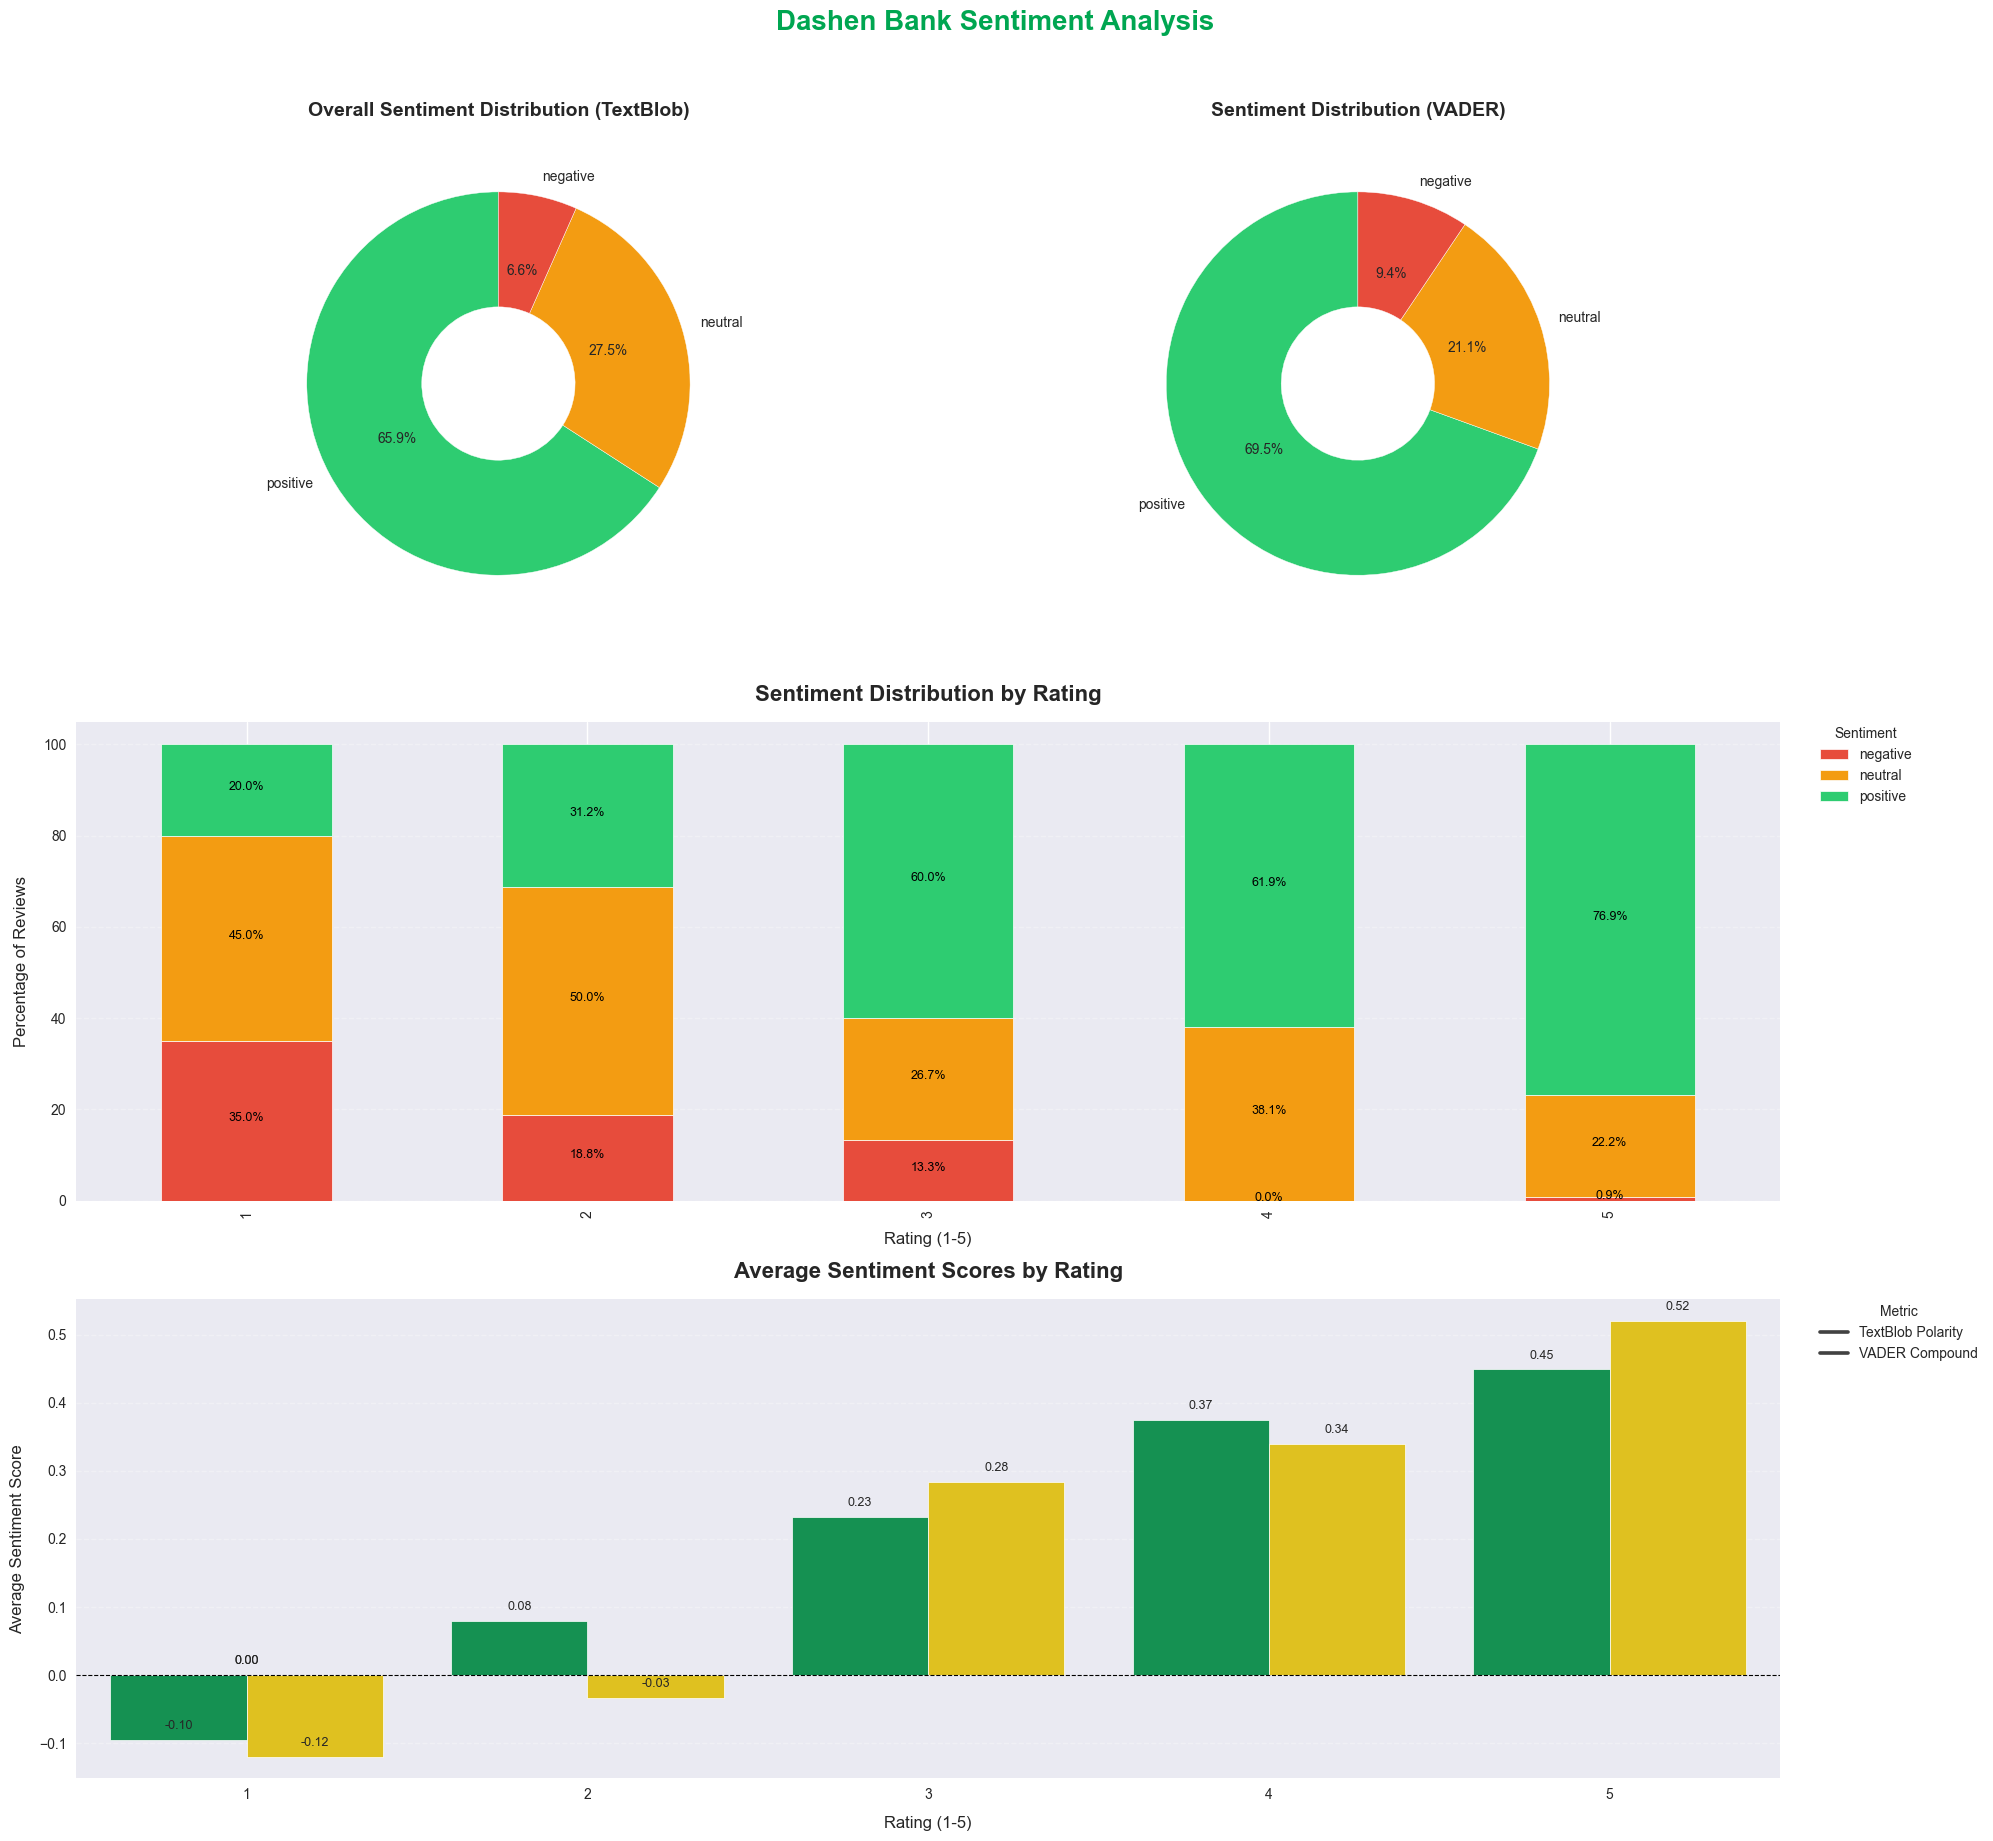

C:\Users\My Device\AppData\Local\Temp\ipykernel_15200\529013962.py:170: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = time_series[['polarity', 'vader_compound']].resample('M').mean()


✅ Time series visualization saved to C:/Users/My Device/Desktop/Week-2/data\..\reports\figures\dashen_sentiment_over_time.png


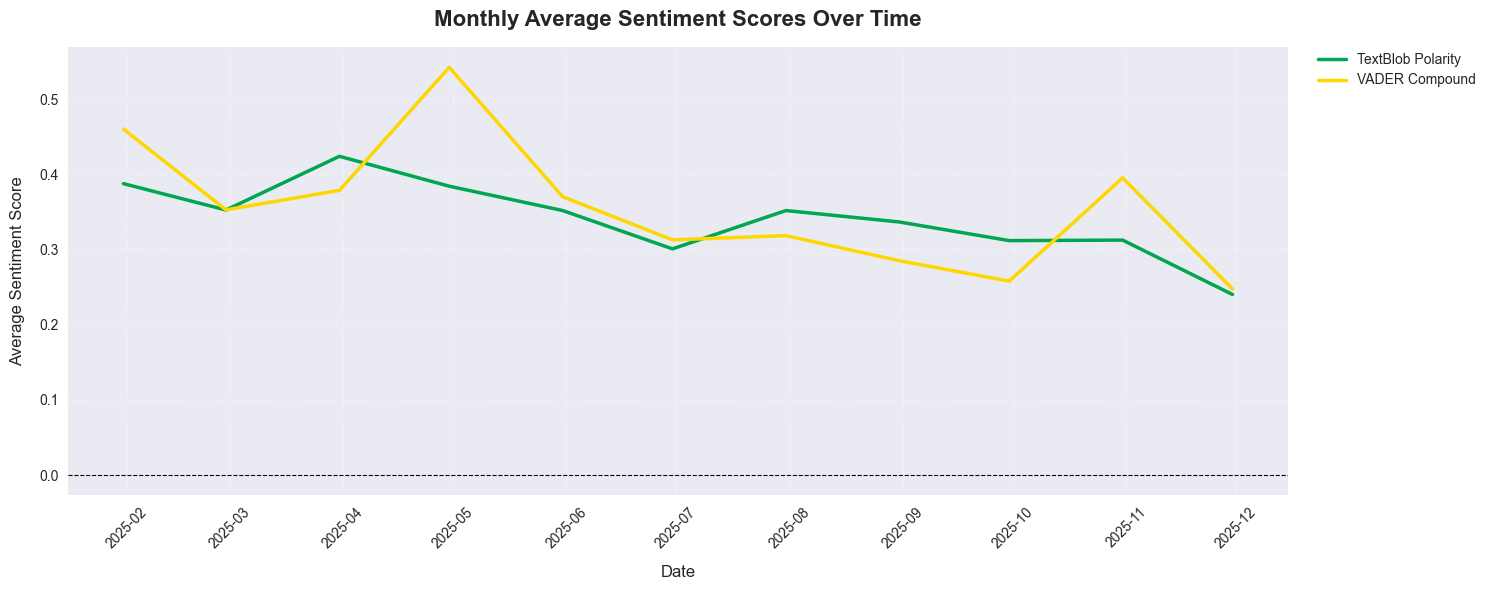

✅ Visualizations generated successfully!
Visualizations saved to: C:\Users\My Device\Desktop\Week-2\reports\figures


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pathlib import Path
import os

# 1. Load your cleaned CSV file
file_path = r'C:/Users/My Device/Desktop/Week-2/data/bank_reviews_dashen.csv'
try:
    df = pd.read_csv(file_path)
    print("✅ File loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nFirst few rows:")
    display(df.head())
    
except Exception as e:
    print(f"❌ Error loading file: {e}")
    raise

# 2. Check for required columns
print("\nChecking for required columns...")
required_columns = ['review']  # Minimum required
for col in required_columns:
    if col not in df.columns:
        print(f"⚠️ Missing column: {col}")

# 3. Initialize sentiment analyzers
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """Analyze sentiment using both TextBlob and VADER"""
    try:
        # TextBlob analysis
        blob = TextBlob(str(text))
        polarity = blob.sentiment.polarity
        sentiment = 'positive' if polarity > 0.1 else 'negative' if polarity < -0.1 else 'neutral'
        
        # VADER analysis
        vader_scores = analyzer.polarity_scores(str(text))
        vader_compound = vader_scores['compound']
        vader_sentiment = 'positive' if vader_compound > 0.05 else 'negative' if vader_compound < -0.05 else 'neutral'
        
        return pd.Series([polarity, sentiment, vader_compound, vader_sentiment])
    except Exception as e:
        print(f"Error analyzing text: {e}")
        return pd.Series([0, 'neutral', 0, 'neutral'])

# 4. Analyze sentiment if needed
if not all(col in df.columns for col in ['polarity', 'sentiment', 'vader_compound', 'vader_sentiment']):
    print("\nAnalyzing sentiment...")
    df[['polarity', 'sentiment', 'vader_compound', 'vader_sentiment']] = df['review'].apply(analyze_sentiment)

# 5. Check for date column (optional)
if 'date' in df.columns:
    try:
        df['date'] = pd.to_datetime(df['date'])
        print("\nDate column found and converted to datetime")
    except:
        print("\nCould not convert date column to datetime")

# 6. Display basic info
print("\nDataFrame Info:")
display(df.info())
print("\nSentiment Distribution (TextBlob):")
display(df['sentiment'].value_counts())
print("\nSentiment Distribution (VADER):")
display(df['vader_sentiment'].value_counts())

# 7. Now you can call your plotting function
print("\nGenerating visualizations...")
try:
    # Create output directory if it doesn't exist
    output_dir = os.path.join(os.path.dirname(file_path), '..', 'reports', 'figures')
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Call your plotting function
    plot_dashen_sentiment_analysis(df, save_path=output_dir)
    print("✅ Visualizations generated successfully!")
    print(f"Visualizations saved to: {os.path.abspath(output_dir)}")
except Exception as e:
    print(f"❌ Error generating visualizations: {e}")
    raise

## Visualize Sentiment Analysis

In [23]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load your data
df = pd.read_csv(r'C:\Users\My Device\Desktop\Week-2\data\bank_reviews_dashen.csv')

Analyzing sentiment with TextBlob...
Analyzing sentiment with VADER...
Generating visualizations...


2025-11-30 21:28:00,692 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


✅ Saved: ..\reports\figures\dashen_sentiment_analysis.png


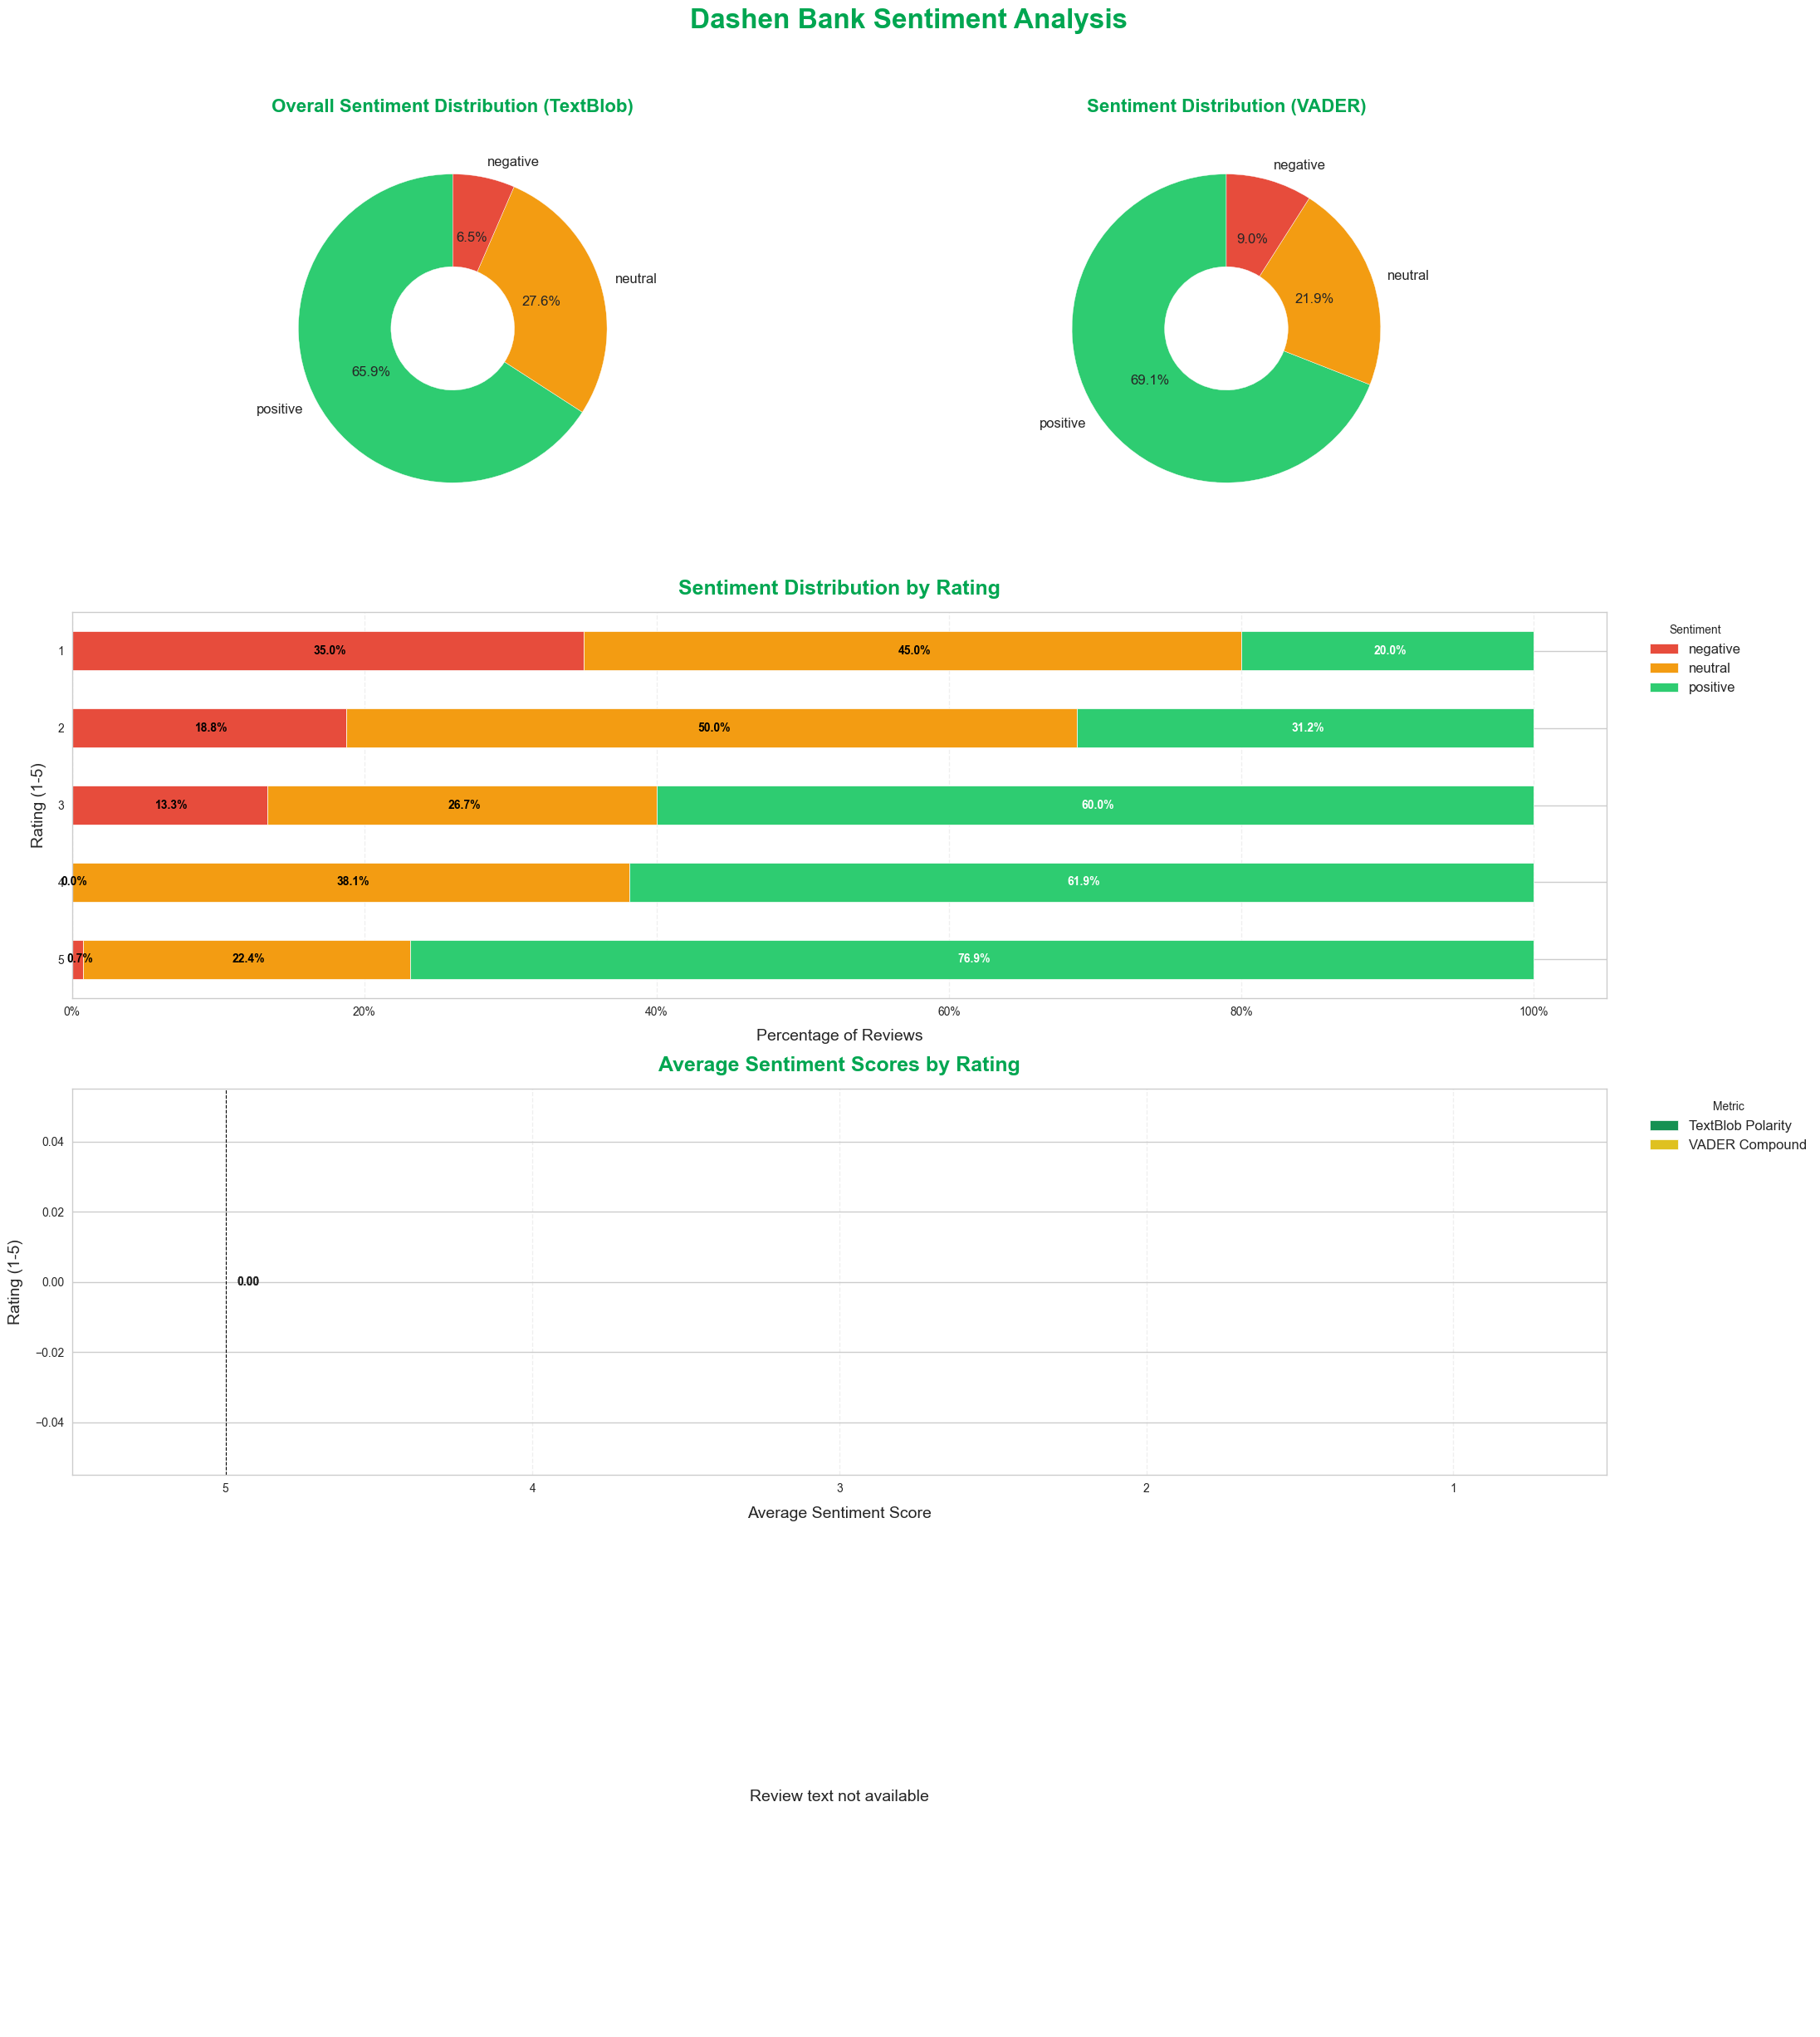

C:\Users\My Device\AppData\Local\Temp\ipykernel_15200\1052961776.py:290: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = time_series[col].resample('M').mean()


✅ Saved: ..\reports\figures\dashen_sentiment_over_time.png


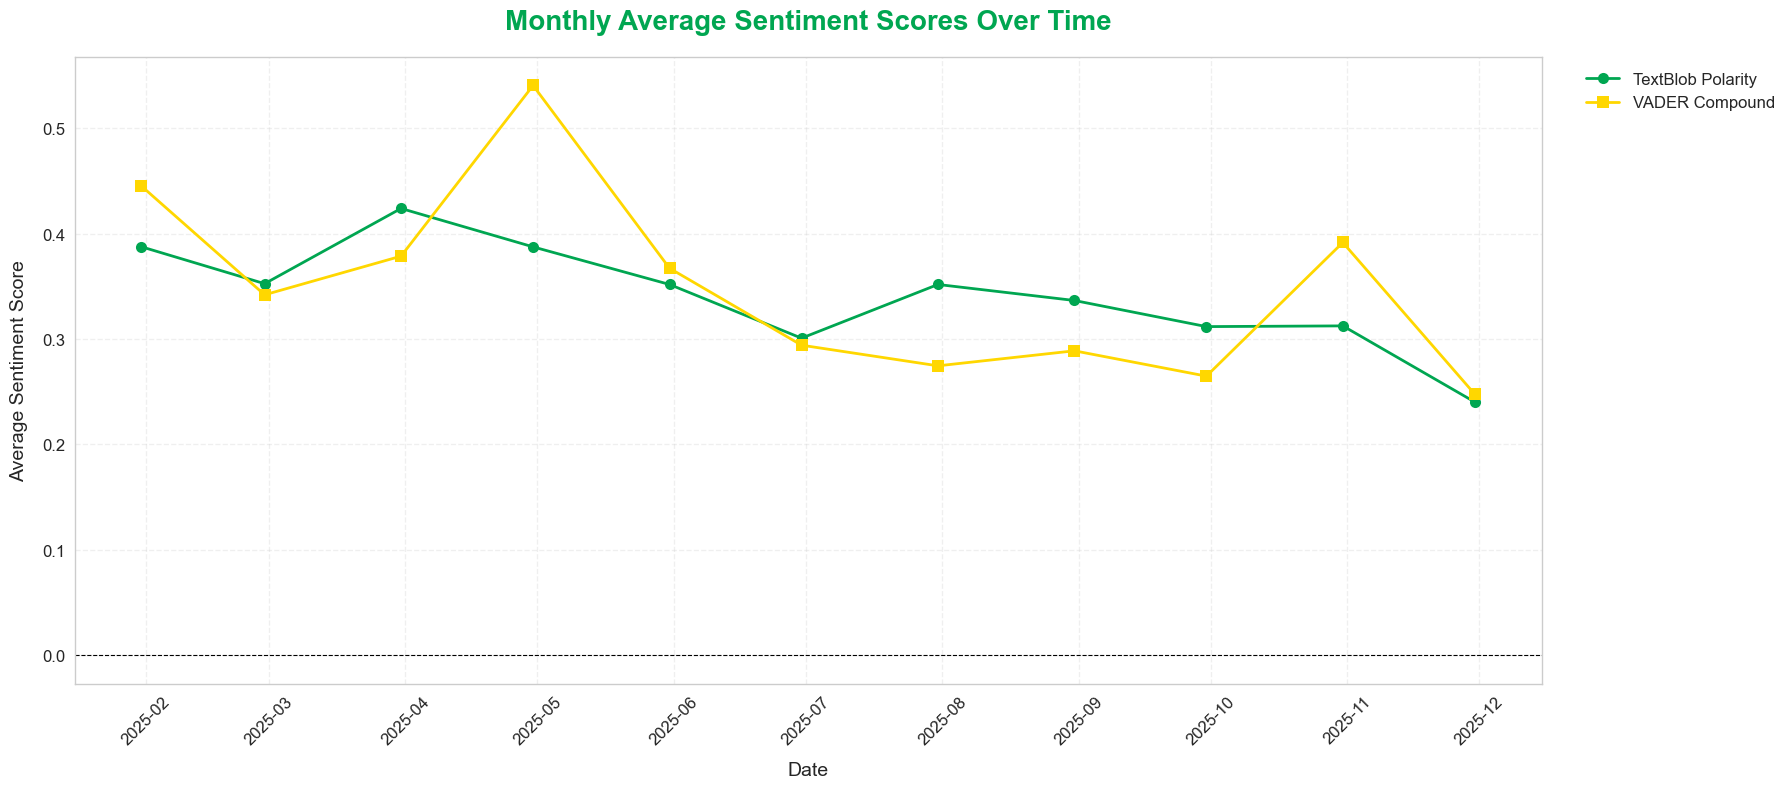

✅ All visualizations completed successfully!

Preview of the data with sentiment analysis:


,review_clean,rating,polarity,vader_compound,sentiment,vader_sentiment
0,The Dashen Super App is very impressive. It is...,5,0.389394,0.9722,positive,positive
1,"@Shewangizaw L. As a heavy user of the app , t...",4,0.185000,0.8313,positive,positive
2,This might be the worst banking app I've ever ...,1,-0.033333,-0.9272,neutral,negative
3,What do you care about my phone's settings? Wh...,1,0.250000,0.3736,positive,positive
4,The Dashen Super App is very impressive. It is...,5,0.389394,0.9722,positive,positive


In [26]:

# 2. Initialize sentiment analyzers
analyzer = SentimentIntensityAnalyzer()

# 3. Add TextBlob sentiment analysis
print("Analyzing sentiment with TextBlob...")
df['polarity'] = df['review_clean'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['review_clean'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# 4. Add VADER sentiment analysis
print("Analyzing sentiment with VADER...")
df['vader_scores'] = df['review_clean'].apply(lambda x: analyzer.polarity_scores(str(x)))
df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'])

# 5. Categorize sentiments
def categorize_sentiment(score, method='textblob'):
    if method == 'textblob':
        if score > 0.1:
            return 'positive'
        elif score < -0.1:
            return 'negative'
        else:
            return 'neutral'
    else:  # vader
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'

df['sentiment'] = df['polarity'].apply(lambda x: categorize_sentiment(x, 'textblob'))
df['vader_sentiment'] = df['vader_compound'].apply(lambda x: categorize_sentiment(x, 'vader'))

# 6. Now call your plotting function
print("Generating visualizations...")
plot_dashen_sentiment_analysis(df)

# 7. Show the first few rows with the new columns
print("\nPreview of the data with sentiment analysis:")
display(df[['review_clean', 'rating', 'polarity', 'vader_compound', 'sentiment', 'vader_sentiment']].head())

## Analysis of BOA Sentiment by Rating

✅ Saved: ..\reports\figures\dashen_sentiment_by_rating.png

Detailed Sentiment Analysis by Rating:


C:\Users\My Device\AppData\Local\Temp\ipykernel_15200\637896077.py:251: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_negative_red, subset=['Avg_Polarity', 'Avg_VADER'])


,Total,Positive,Neutral,Negative,Avg_Polarity,Avg_VADER
rating,,,,,,
1,100,18.0%,47.0%,35.0%,-0.13,0.42
2,32,37.5%,46.9%,15.6%,0.12,0.50
3,30,53.3%,33.3%,13.3%,0.23,0.67
4,42,54.8%,40.5%,4.8%,0.37,0.70
5,549,71.8%,27.9%,0.4%,0.45,0.76


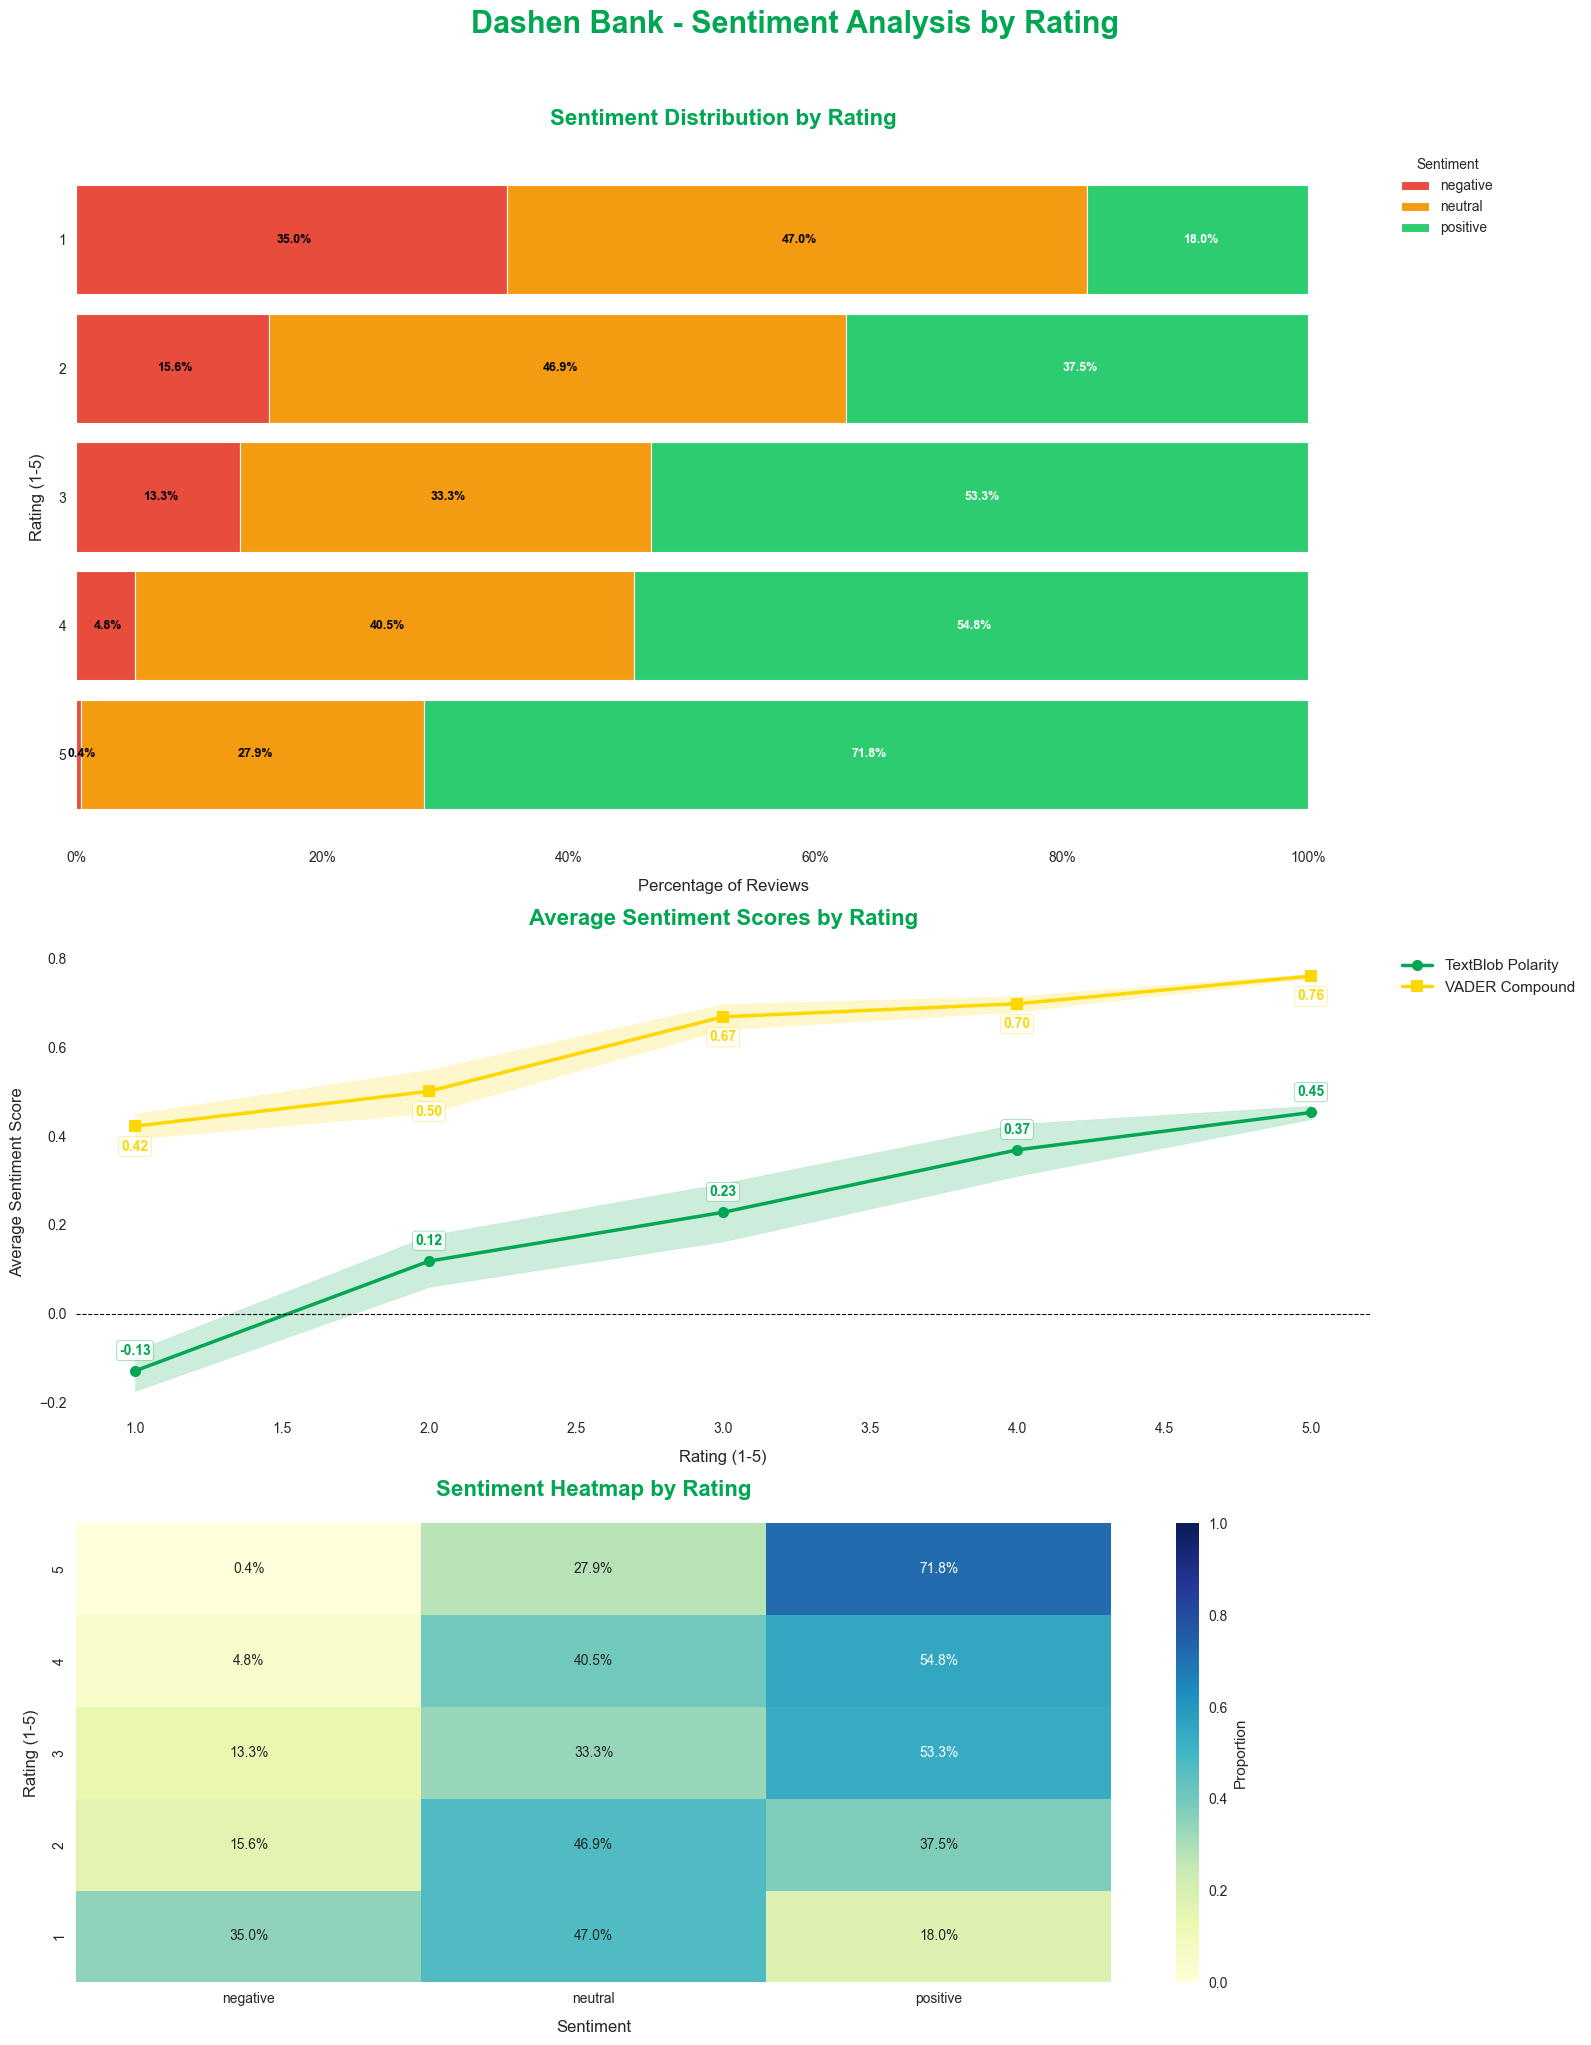

In [28]:
def plot_dashen_sentiment_by_rating(dashen_analyzed, save_path='../reports/figures'):
    """
    Generate detailed sentiment analysis visualizations by rating for Dashen Bank.
    """
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from matplotlib.ticker import PercentFormatter
    from pathlib import Path
    from textwrap import fill
    import matplotlib as mpl
    
    # Set style and colors
    plt.style.use('seaborn-v0_8')
    sns.set_palette("viridis")
    mpl.rcParams['figure.facecolor'] = 'white'
    mpl.rcParams['axes.facecolor'] = 'white'
    
    # Dashen Bank color scheme
    COLORS = {
        'primary': '#00A651',    # Dashen Green
        'secondary': '#FFD700',  # Gold
        'accent': '#003366',     # Dark Blue
        'success': '#2ecc71',    # Green
        'warning': '#f39c12',    # Orange
        'danger': '#e74c3c'      # Red
    }
    
    # Create output directory if it doesn't exist
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)
    
    if dashen_analyzed is None or dashen_analyzed.empty:
        print("❌ No Dashen Bank data available for visualization")
        return
    
    # Helper function to save plots
    def save_plot(fig, filename, dpi=300):
        try:
            filepath = save_path / filename
            fig.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white')
            print(f"✅ Saved: {filepath}")
            return filepath
        except Exception as e:
            print(f"⚠️ Error saving {filename}: {str(e)}")
            return None

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 20))
    gs = fig.add_gridspec(3, 1, height_ratios=[1.5, 1, 1])
    fig.suptitle('Dashen Bank - Sentiment Analysis by Rating', 
                 fontsize=22, y=1.02, weight='bold', 
                 color=COLORS['primary'])
    
    # 1. Sentiment Distribution by Rating (Stacked Bar Chart)
    ax1 = fig.add_subplot(gs[0])
    if 'rating' in dashen_analyzed.columns and 'sentiment' in dashen_analyzed.columns:
        # Create cross-tabulation
        sentiment_by_rating = pd.crosstab(
            dashen_analyzed['rating'], 
            dashen_analyzed['sentiment'],
            normalize='index'
        ).sort_index(ascending=False) * 100
        
        # Define colors for each sentiment
        sentiment_colors = {
            'positive': COLORS['success'],
            'neutral': COLORS['warning'],
            'negative': COLORS['danger']
        }
        
        # Reorder columns to ensure consistent color mapping
        sentiment_order = ['negative', 'neutral', 'positive']
        sentiment_by_rating = sentiment_by_rating[sentiment_order]
        
        # Plot stacked bars
        sentiment_by_rating.plot(
            kind='barh', 
            stacked=True, 
            ax=ax1,
            color=[sentiment_colors[s] for s in sentiment_order],
            edgecolor='white',
            linewidth=0.8,
            width=0.85
        )
        
        # Customize the plot
        ax1.set_title('Sentiment Distribution by Rating', 
                     fontsize=16, pad=20, weight='bold', 
                     color=COLORS['primary'])
        ax1.set_xlabel('Percentage of Reviews', fontsize=12, labelpad=10)
        ax1.set_ylabel('Rating (1-5)', fontsize=12, labelpad=10)
        ax1.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), 
                  loc='upper left', borderaxespad=0.)
        ax1.grid(axis='x', linestyle='--', alpha=0.3)
        ax1.xaxis.set_major_formatter(PercentFormatter(100))
        
        # Add percentage labels on each segment
        for container in ax1.containers:
            ax1.bar_label(
                container, 
                label_type='center', 
                fmt='%.1f%%',
                color='white' if container.datavalues[0] > 30 else 'black',
                fontsize=9,
                fontweight='bold',
                padding=2
            )
    
    # 2. Average Sentiment Scores by Rating (Line Plot)
    ax2 = fig.add_subplot(gs[1])
    if 'rating' in dashen_analyzed.columns:
        # Calculate average scores with error margins
        avg_scores = dashen_analyzed.groupby('rating').agg({
            'polarity': ['mean', 'sem'],
            'vader_compound': ['mean', 'sem']
        }).reset_index()
        
        # Flatten column names
        avg_scores.columns = ['_'.join(col).strip('_') for col in avg_scores.columns.values]
        
        # Create line plot with error bands
        for metric, color, label in [
            ('polarity', COLORS['primary'], 'TextBlob Polarity'),
            ('vader_compound', COLORS['secondary'], 'VADER Compound')
        ]:
            # Plot the main line
            ax2.plot(
                avg_scores['rating'], 
                avg_scores[f'{metric}_mean'],
                color=color,
                marker='o' if metric == 'polarity' else 's',
                markersize=8,
                linewidth=2.5,
                label=label
            )
            
            # Add error bands (standard error of the mean)
            ax2.fill_between(
                avg_scores['rating'],
                avg_scores[f'{metric}_mean'] - avg_scores[f'{metric}_sem'],
                avg_scores[f'{metric}_mean'] + avg_scores[f'{metric}_sem'],
                color=color,
                alpha=0.2
            )
        
        # Customize the plot
        ax2.set_title('Average Sentiment Scores by Rating', 
                     fontsize=16, pad=20, weight='bold', 
                     color=COLORS['primary'])
        ax2.set_xlabel('Rating (1-5)', fontsize=12, labelpad=10)
        ax2.set_ylabel('Average Sentiment Score', fontsize=12, labelpad=10)
        ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
        ax2.legend(
            bbox_to_anchor=(1.02, 1), 
            loc='upper left', 
            borderaxespad=0.,
            fontsize=11
        )
        ax2.grid(True, linestyle='--', alpha=0.3)
        
        # Add value labels
        for _, row in avg_scores.iterrows():
            for metric, color, offset in [
                ('polarity', COLORS['primary'], 0.03),
                ('vader_compound', COLORS['secondary'], -0.03)
            ]:
                ax2.text(
                    row['rating'], 
                    row[f'{metric}_mean'] + offset, 
                    f"{row[f'{metric}_mean']:.2f}",
                    ha='center',
                    va='bottom' if metric == 'polarity' else 'top',
                    fontsize=10,
                    fontweight='bold',
                    color=color,
                    bbox=dict(
                        facecolor='white',
                        edgecolor=color,
                        alpha=0.8,
                        boxstyle='round,pad=0.2'
                    )
                )
    
    # 3. Sentiment Heatmap by Rating
    ax3 = fig.add_subplot(gs[2])
    if all(col in dashen_analyzed.columns for col in ['rating', 'sentiment']):
        # Create cross-tabulation for heatmap
        heatmap_data = pd.crosstab(
            dashen_analyzed['rating'], 
            dashen_analyzed['sentiment'],
            normalize='index'
        ).sort_index(ascending=False)
        
        # Create heatmap
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt='.1%',
            cmap='YlGnBu',
            cbar_kws={'label': 'Proportion'},
            ax=ax3,
            vmin=0,
            vmax=1
        )
        
        # Customize the plot
        ax3.set_title('Sentiment Heatmap by Rating', 
                     fontsize=16, pad=20, weight='bold', 
                     color=COLORS['primary'])
        ax3.set_xlabel('Sentiment', fontsize=12, labelpad=10)
        ax3.set_ylabel('Rating (1-5)', fontsize=12, labelpad=10)
        ax3.tick_params(axis='both', which='major', labelsize=10)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    save_plot(fig, 'dashen_sentiment_by_rating.png')
    
    # 4. Create a detailed table of sentiment distribution
    if 'rating' in dashen_analyzed.columns:
        # Calculate statistics with consistent column names
        stats = dashen_analyzed.groupby('rating').agg(
            Total=('sentiment', 'count'),
            Positive=('sentiment', lambda x: (x == 'positive').mean() * 100),
            Neutral=('sentiment', lambda x: (x == 'neutral').mean() * 100),
            Negative=('sentiment', lambda x: (x == 'negative').mean() * 100),
            Avg_Polarity=('polarity', 'mean'),
            Avg_VADER=('vader_compound', 'mean')
        ).round(2)
        
        # Display the table with styling
        def color_negative_red(val):
            if isinstance(val, (int, float)):
                if val < 0:
                    return 'color: red'
                elif val > 0:
                    return 'color: green'
            return ''

        # Apply styling
        styled_stats = stats.style\
            .background_gradient(subset=['Avg_Polarity', 'Avg_VADER'], 
                               cmap='RdYlGn', 
                               vmin=-1, vmax=1)\
            .format('{:.1f}%', subset=['Positive', 'Neutral', 'Negative'])\
            .format('{:.2f}', subset=['Avg_Polarity', 'Avg_VADER'])\
            .applymap(color_negative_red, subset=['Avg_Polarity', 'Avg_VADER'])
        
        print("\nDetailed Sentiment Analysis by Rating:")
        display(styled_stats)
    
    plt.show()
    return stats

# Example usage:
if __name__ == "__main__":
    # Assuming you have your analyzed Dashen data
    # dashen_analyzed = analyze_dashen_sentiments(dashen_data)
    
    if 'dashen_analyzed' in locals() and dashen_analyzed is not None:
        stats = plot_dashen_sentiment_by_rating(dashen_analyzed)
    else:
        print("No Dashen Bank data available for visualization")

## Save the Results

In [30]:
def save_sentiment_analysis_results(dashen_analyzed, output_dir='../reports/results'):
    """
    Save the sentiment analysis results to Excel and CSV files.
    
    Args:
        dashen_analyzed (pd.DataFrame): DataFrame containing the analyzed data
        output_dir (str): Directory to save the output files
    """
    import os
    import pandas as pd
    from pathlib import Path
    from datetime import datetime
    
    # Create output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Generate timestamp for filenames
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # 1. Save the full analyzed dataset
    full_output_path = output_path / f'dashen_sentiment_analysis_{timestamp}.xlsx'
    try:
        with pd.ExcelWriter(full_output_path, engine='openpyxl') as writer:
            # Save the full dataset
            dashen_analyzed.to_excel(writer, sheet_name='Full Analysis', index=False)
            
            # Save summary statistics
            if 'rating' in dashen_analyzed.columns:
                # Basic statistics
                stats = dashen_analyzed.groupby('rating').agg({
                    'sentiment': ['count', 
                                ('positive', lambda x: (x == 'positive').mean() * 100),
                                ('neutral', lambda x: (x == 'neutral').mean() * 100),
                                ('negative', lambda x: (x == 'negative').mean() * 100)],
                    'polarity': ['mean', 'std', 'min', 'max'],
                    'vader_compound': ['mean', 'std', 'min', 'max']
                }).round(2)
                
                # Flatten multi-index columns
                stats.columns = ['_'.join(col).strip('_') for col in stats.columns.values]
                stats.to_excel(writer, sheet_name='Summary Statistics')
            
            # Save sentiment distribution
            if 'sentiment' in dashen_analyzed.columns:
                sentiment_dist = dashen_analyzed['sentiment'].value_counts(normalize=True).mul(100).round(2)
                sentiment_dist.to_excel(writer, sheet_name='Sentiment Distribution')
                
        print(f"✅ Analysis results saved to: {full_output_path}")
        
        # 2. Save a simplified CSV version
        csv_output_path = output_path / f'dashen_sentiment_summary_{timestamp}.csv'
        if 'rating' in dashen_analyzed.columns:
            # Create a simplified summary
            summary = dashen_analyzed.groupby('rating').agg({
                'sentiment': ['count', 
                            ('positive', lambda x: (x == 'positive').mean() * 100),
                            ('neutral', lambda x: (x == 'neutral').mean() * 100),
                            ('negative', lambda x: (x == 'negative').mean() * 100)],
                'polarity': ['mean', 'std'],
                'vader_compound': ['mean', 'std']
            }).round(2)
            
            # Flatten column names
            summary.columns = ['_'.join(col).strip('_') for col in summary.columns.values]
            summary.to_csv(csv_output_path)
            print(f"✅ Summary saved to: {csv_output_path}")
        
        return str(full_output_path)
    
    except Exception as e:
        print(f"❌ Error saving results: {str(e)}")
        return None

# Example usage:
if __name__ == "__main__":
    # Assuming you have your analyzed data in 'dashen_analyzed'
    if 'dashen_analyzed' in locals() and dashen_analyzed is not None:
        save_sentiment_analysis_results(dashen_analyzed)
    else:
        print("No data available to save. Please analyze your data first.")

✅ Analysis results saved to: ..\reports\results\dashen_sentiment_analysis_20251130_214031.xlsx
✅ Summary saved to: ..\reports\results\dashen_sentiment_summary_20251130_214031.csv


## General Summary Report

In [31]:
def generate_dashen_summary(dashen_analyzed, output_file='../reports/dashen_sentiment_summary.md'):
    """Generate a markdown summary report for Dashen Bank sentiment analysis"""
    from pathlib import Path
    from datetime import datetime
    
    if dashen_analyzed is None or dashen_analyzed.empty:
        print("❌ No Dashen Bank data available for report generation")
        return

    # Setup output directory
    report_path = Path(output_file)
    report_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Calculate statistics
    total = len(dashen_analyzed)
    tb_sent = dashen_analyzed['sentiment'].value_counts()
    vd_sent = dashen_analyzed['vader_sentiment'].value_counts()
    rating_dist = dashen_analyzed['rating'].value_counts().sort_index() if 'rating' in dashen_analyzed else {}
    date_range = f"{dashen_analyzed['date'].min().strftime('%Y-%m-%d')} to {dashen_analyzed['date'].max().strftime('%Y-%m-%d')}" if 'date' in dashen_analyzed else "N/A"

    # Sentiment percentages
    tb_pos = (tb_sent.get('positive', 0) / total) * 100
    tb_neu = (tb_sent.get('neutral', 0) / total) * 100
    tb_neg = (tb_sent.get('negative', 0) / total) * 100
    
    vd_pos = (vd_sent.get('positive', 0) / total) * 100
    vd_neu = (vd_sent.get('neutral', 0) / total) * 100
    vd_neg = (vd_sent.get('negative', 0) / total) * 100

    # Generate report
    report = f"""# Dashen Bank Sentiment Analysis Report

## Overview
This report summarizes the sentiment analysis of {total:,} Dashen Bank reviews.

## Key Statistics
- **Total Reviews**: {total:,}
- **Date Range**: {date_range}

## Sentiment Analysis

### TextBlob Analysis
- Positive: {tb_sent.get('positive', 0):,} ({tb_pos:.1f}%)
- Neutral: {tb_sent.get('neutral', 0):,} ({tb_neu:.1f}%)
- Negative: {tb_sent.get('negative', 0):,} ({tb_neg:.1f}%)

### VADER Analysis
- Positive: {vd_sent.get('positive', 0):,} ({vd_pos:.1f}%)
- Neutral: {vd_sent.get('neutral', 0):,} ({vd_neu:.1f}%)
- Negative: {vd_sent.get('negative', 0):,} ({vd_neg:.1f}%)

## Rating Distribution
{chr(10).join(f"- {star}★: {count:,} ({(count/total):.1%})" for star, count in rating_dist.items())}

## Visualizations
![Sentiment Distribution](../reports/figures/dashen_sentiment_distribution.png)
![Sentiment by Rating](../reports/figures/dashen_sentiment_by_rating.png)
![Sentiment Over Time](../reports/figures/dashen_sentiment_over_time.png)

---

*Report generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*
"""

    # Save the report
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report)
    
    print(f"✅ Report generated: {report_path}")

# Example usage:
if __name__ == "__main__":
    if 'dashen_analyzed' in locals() and dashen_analyzed is not None:
        generate_dashen_summary(dashen_analyzed)
    else:
        print("No Dashen Bank data available for report generation")

✅ Report generated: ..\reports\dashen_sentiment_summary.md
